- 用overfit後調好的模型再行訓練
- 增加搖動影像
- 吃15000 的GKF 1 - 4
- 改過data generator
- 改過load npz
- 純吃R02

## 訓練模型

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import time
from scipy.ndimage.interpolation import shift,rotate,zoom

In [10]:
def chaos_aug64_simple(img_npz, shift_random=0):
    cond_2 = random.randint(0, 31)
        
    if cond_2 == 0:
        img_npz = shift(img_npz, [1, 0, 0], cval=0)  # 往下
    if cond_2 == 1:
        img_npz = shift(img_npz, [-1, 0, 0], cval=0)  # 往上
    if cond_2 == 2:
        img_npz = shift(img_npz, [0, 1, 0], cval=0)  # 往右
    if cond_2 == 3:
        img_npz = shift(img_npz, [0, -1, 0], cval=0)  # 往左
    if cond_2 == 4:
        img_npz = shift(img_npz, [2, 0, 0], cval=0)  # 往下
    if cond_2 == 5:
        img_npz = shift(img_npz, [-2, 0, 0], cval=0)  # 往上
    if cond_2 == 6:
        img_npz = shift(img_npz, [0, 2, 0], cval=0)  # 往右
    if cond_2 == 7:
        img_npz = shift(img_npz, [0, -2, 0], cval=0)  # 往左
    
    return img_npz

In [11]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def load_npz(img):
    img_array = np.load(img)['arr_0'].T.reshape((128, 128, 64))       
#     img_array = np.where(img_array < 4096, img_array, 4096)
#     img_array = np.where(img_array > -1024, img_array, -1024)
    return (img_array - img_array.min()) / (img_array.max() - img_array.min())

def load_npz_img_chaos(img):
    #return chaos_aug64(load_npz(img), max_shift_pixel=5, shift_random=1)
    return chaos_aug64_simple(load_npz(img))

class DataGenerator(tf.keras.utils.Sequence):
    """
    Keras Sequence object to train a model on larger-than-memory data.
    """

    def __init__(self, df, data_path, batch_size, dim=(128, 128, 64), n_channels=1, shuffle=True, concat=False, chaos=False):
        "Initialization"
        self.df = df
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.concat = concat
        self.chaos = chaos
        self.df['name'] = self.df['GKF'] + '/' + \
            self.df['case'] + '/' + self.df['final_key'] + '.npz'
        self.img_list = self.df['name'].apply(
            lambda x: os.path.join(data_path, x)).tolist()
        self.y = self.df['label'].replace(['Y', 'N'], [1, 0])
        self.incidies = np.arange(self.df.shape[0])
        self.on_epoch_end()

    def __len__(self):
        'Calculate the number of iterations of each epoch'
        return int(math.ceil(len(self.df) / float(self.batch_size)))

    def get_batch_image_features(self, idx):
        'Fetch a batch of inputs'
        ics = self.incidies[idx * self.batch_size: (1 + idx) * self.batch_size]
        
        img_shuffle_list = [self.img_list[loc] for loc in [id for id in ics]]
        
#         self.img_list[self.incidies[idx * self.batch_size: (1 + idx) * self.batch_size]]]
#         self.img_list[self.incidies[idx * self.batch_size: (1 + idx) * self.batch_size]]]
        if self.chaos:
            return np.array([load_npz_img_chaos(img) for img in img_shuffle_list])
        else:
            return np.array([load_npz_img(img) for img in img_shuffle_list])

    def __getitem__(self, idx):
        'Generate one batch of data'
        ics = self.incidies[idx * self.batch_size: (1 + idx) * self.batch_size]

        if self.concat:
            batch_x = [self.get_batch_image_features(idx),
                       self.df.filter(['SEX', 'AGE']).loc[ics].values]
        else:
            batch_x = self.get_batch_image_features(idx)
            
        batch_y = self.y[ics]
        return batch_x, np.array(batch_y)

    def on_epoch_end(self):
        'Shuffles indexes after each epoch if in training mode'
        np.random.shuffle(self.incidies)



In [12]:
def tf_learning_model(img_size=(128, 128, 64)):
    'my transfer learning model'
    
    input_img = Input(shape=img_size)
    
    x = Conv2D(32, kernel_size=(3, 3), activation='relu',
               padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv2D(16, kernel_size=(3, 3), activation='relu',
               padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(3, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    # we add dense layers so that the model can learn more complex functions and classify for better results.
    # final layer with softmax activation for N classes
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    preds = Dense(1, activation='sigmoid')(x)  
    
    tf_model = tf.keras.Model(inputs=input_img, outputs=preds, name='tranfer_model')

    return tf_model

# read data

In [13]:
# 訓練次數
# epochs = 5
# 資料mapping表
df_tmp = pd.read_csv('./tf_init_0810.csv')
df_tmp

,GKF,case,final_key,label,maximum,minimum
0,test,case,P1887_S01_R01_Y_S1,Y,1598,-2048
1,test,case,P1887_S01_R02_Y_S1,Y,1645,-2048
2,train,case,P2310_S01_R03_Y_S1,Y,1471,-2048
3,train,case,P2310_S01_R02_Y_S1,Y,1504,-2048
4,train,case,P2310_S01_R01_Y_S1,Y,1489,-2048
...,...,...,...,...,...,...
15120,train,control,P2506_S01_R02_N_S1,N,1543,-3024
15121,train,control,P2506_S01_R03_N_S1,N,1128,-3024
15122,train,control,P6075_S01_R02_N_S1,N,1581,-1024
15123,train,control,P6075_S01_R01_N_S1,N,1574,-1024


In [14]:
df_tmp['study'] = df_tmp.final_key.str.split('_', expand=True)[1]
df_tmp['series'] = df_tmp.final_key.str.split('_', expand=True)[2]
df_tmp['PATIENT'] = df_tmp.final_key.str.split('_', expand=True)[0]
df_tmp['PATIENT'] = df_tmp.PATIENT.str.split('P',expand=True)[1]
# df_tmp['STUDY'] = df_tmp.final_key.str.split('_', expand=True)[1]
# df_tmp['STUDY'] = df_tmp.STUDY.str.split('S',expand=True)[1]
df_tmp['KEY_ID'] = 'psuedoID_' + df_tmp.PATIENT + '_S0' + df_tmp.study
df_tmp

,GKF,case,final_key,label,maximum,minimum,study,series,PATIENT,KEY_ID
0,test,case,P1887_S01_R01_Y_S1,Y,1598,-2048,S01,R01,1887,psuedoID_1887_S0S01
1,test,case,P1887_S01_R02_Y_S1,Y,1645,-2048,S01,R02,1887,psuedoID_1887_S0S01
2,train,case,P2310_S01_R03_Y_S1,Y,1471,-2048,S01,R03,2310,psuedoID_2310_S0S01
3,train,case,P2310_S01_R02_Y_S1,Y,1504,-2048,S01,R02,2310,psuedoID_2310_S0S01
4,train,case,P2310_S01_R01_Y_S1,Y,1489,-2048,S01,R01,2310,psuedoID_2310_S0S01
...,...,...,...,...,...,...,...,...,...,...
15120,train,control,P2506_S01_R02_N_S1,N,1543,-3024,S01,R02,2506,psuedoID_2506_S0S01
15121,train,control,P2506_S01_R03_N_S1,N,1128,-3024,S01,R03,2506,psuedoID_2506_S0S01
15122,train,control,P6075_S01_R02_N_S1,N,1581,-1024,S01,R02,6075,psuedoID_6075_S0S01
15123,train,control,P6075_S01_R01_N_S1,N,1574,-1024,S01,R01,6075,psuedoID_6075_S0S01


In [6]:
#df_train = df_tmp.loc[df_tmp.series == 'R01'].sample(5304, random_state=123).reset_index(drop=True)
df_train = df_tmp.loc[df_tmp.GKF=='train'].reset_index(drop=True)
df_train = df_train.loc[df_train.series=='R02'].reset_index(drop=True)
df_train = df_train.sample(df_train.shape[0], random_state=914).reset_index(drop=True)
df_train

,GKF,case,final_key,label,maximum,minimum,study,series,PATIENT,KEY_ID
0,train,control,P5769_S01_R02_N_S1,N,1580,-3024,S01,R02,5769,psuedoID_5769_S0S01
1,train,case,P0229_S01_R02_Y_S1,Y,1539,-3024,S01,R02,0229,psuedoID_0229_S0S01
2,train,control,P6160_S01_R02_N_S1,N,964,-3024,S01,R02,6160,psuedoID_6160_S0S01
3,train,control,P4631_S01_R02_N_S1,N,1456,-3024,S01,R02,4631,psuedoID_4631_S0S01
4,train,control,P5976_S01_R02_N_S1,N,1531,-2048,S01,R02,5976,psuedoID_5976_S0S01
...,...,...,...,...,...,...,...,...,...,...
4074,train,control,P4140_S01_R02_N_S1,N,2756,-1024,S01,R02,4140,psuedoID_4140_S0S01
4075,train,case,P1005_S01_R02_Y_S1,Y,8858,-2048,S01,R02,1005,psuedoID_1005_S0S01
4076,train,control,P3123_S01_R02_N_S1,N,1621,-1024,S01,R02,3123,psuedoID_3123_S0S01
4077,train,control,P4454_S01_R02_N_S1,N,3202,-2048,S01,R02,4454,psuedoID_4454_S0S01


In [7]:
#df_test = df_tmp.loc[(df_tmp.GKF == 'test') & (df_tmp.series == 'R02')].sample(1027, random_state=123).reset_index(drop=True)
df_test = df_tmp.loc[df_tmp.GKF=='test'].reset_index(drop=True)
df_test = df_test.loc[df_test.series=='R02'].reset_index(drop=True)
df_test = df_test.sample(df_test.shape[0], random_state=914).reset_index(drop=True)
df_test

,GKF,case,final_key,label,maximum,minimum,study,series,PATIENT,KEY_ID
0,test,case,P2393_S01_R02_Y_S1,Y,1456,-2048,S01,R02,2393,psuedoID_2393_S0S01
1,test,case,P1727_S01_R02_Y_S1,Y,1497,-2048,S01,R02,1727,psuedoID_1727_S0S01
2,test,case,P0920_S01_R02_Y_S1,Y,9523,-2048,S01,R02,0920,psuedoID_0920_S0S01
3,test,control,P4607_S01_R02_N_S1,N,3070,-3024,S01,R02,4607,psuedoID_4607_S0S01
4,test,control,P5770_S01_R02_N_S1,N,1478,-3024,S01,R02,5770,psuedoID_5770_S0S01
...,...,...,...,...,...,...,...,...,...,...
1022,test,control,P2539_S01_R02_N_S1,N,2203,-1024,S01,R02,2539,psuedoID_2539_S0S01
1023,test,control,P3127_S01_R02_N_S1,N,2505,-3024,S01,R02,3127,psuedoID_3127_S0S01
1024,test,control,P6161_S01_R02_N_S1,N,1995,-2048,S01,R02,6161,psuedoID_6161_S0S01
1025,test,control,P4442_S01_R02_N_S1,N,1447,-1024,S01,R02,4442,psuedoID_4442_S0S01


In [8]:
print(df_train.label.value_counts()[0]/len(df_train))
print(df_test.label.value_counts()[0]/len(df_test))

0.619759745035548
0.6183057448880234


# 先跑兩次測時間，跳過

In [18]:
tf_model = tf.keras.models.load_model('./model/tf_learn_0916_overfit_overnight.h5')
print(tf_model.summary())

Now Preparing autoencoder model.....
Model: "tranfer_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      18464     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      4624      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
dropout_1 (Dropo

In [19]:
# 調整參數
tf_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[['accuracy', tf.keras.metrics.AUC()]])

In [32]:
seq_train = DataGenerator(df_train, '../data/folder_128/', batch_size=128, chaos=True)
seq_test = DataGenerator(df_test, '../data/folder_128/', batch_size=128, chaos=True)

In [33]:
import logging
logging.disable(logging.WARNING)
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [34]:
checkpointer = ModelCheckpoint(filepath='../callbacks/last0929/chaos_after_overfit_{epoch:03d}_0929.h5',
                               verbose=1,
                               save_best_only=False,
                               save_freq='epoch',
                               period=10)

## 0916 訓練結果

In [35]:
# 模型訓練
history = tf_model.fit_generator(generator=seq_train, epochs=2, verbose=1, 
                                 validation_data=seq_test,
                                 use_multiprocessing=False, workers=4, 
                                 callbacks=[checkpointer])

Epoch 1/2
 8/32 [======>.......................] - ETA: 52s - loss: 1.1848 - accuracy: 0.7705 - auc_1: 0.7926

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in short_scalars
  import sys


32/32 [==============================] - 210s 7s/step - loss: 0.9424 - accuracy: 0.7492 - auc_1: 0.7833 - val_loss: 2.1615 - val_accuracy: 0.6456 - val_auc_1: 0.6153
Epoch 2/2
32/32 [==============================] - 210s 7s/step - loss: 0.6024 - accuracy: 0.7541 - auc_1: 0.7962 - val_loss: 1.8875 - val_accuracy: 0.6222 - val_auc_1: 0.6799


- 

In [36]:
# 儲存模型
tf_model.save('./model/model2_last_ty_2epoch_0929.h5')

# 跑50次

In [9]:
tf_model = tf.keras.models.load_model('./model/model2_last_ty_2epoch_0929.h5')
print(tf_model.summary())

Model: "tranfer_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      18464     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      4624      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 16)    

In [10]:
tf_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[['accuracy', tf.keras.metrics.AUC()]])

In [11]:
seq_train = DataGenerator(df_train, '../data/folder_128/', batch_size=128, chaos=True)
seq_test = DataGenerator(df_test, '../data/folder_128/', batch_size=128, chaos=True)

In [12]:
import logging
logging.disable(logging.WARNING)

In [13]:
checkpointer = ModelCheckpoint(filepath='../callbacks/last0929/chaos_after_overfit_{epoch:03d}_0929.h5',
                               verbose=1,
                               save_best_only=False,
                               save_freq='epoch',
                               period=5)

In [14]:
history = tf_model.fit_generator(generator=seq_train, epochs=50, verbose=1, 
                                 validation_data=seq_test,
                                 use_multiprocessing=False, workers=4, 
                                 callbacks=[checkpointer])

Epoch 1/50
19/32 [================>.............] - ETA: 48s - loss: 0.6545 - accuracy: 0.7159 - auc: 0.7702

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in short_scalars
  import sys


32/32 [==============================] - 204s 6s/step - loss: 0.6254 - accuracy: 0.7296 - auc: 0.7776 - val_loss: 1.1913 - val_accuracy: 0.6426 - val_auc: 0.6714
Epoch 2/50
32/32 [==============================] - 201s 6s/step - loss: 0.6023 - accuracy: 0.7335 - auc: 0.7794 - val_loss: 1.1971 - val_accuracy: 0.6241 - val_auc: 0.7079
Epoch 3/50
32/32 [==============================] - 206s 6s/step - loss: 0.5250 - accuracy: 0.7602 - auc: 0.8126 - val_loss: 0.7803 - val_accuracy: 0.6680 - val_auc: 0.7642
Epoch 4/50
32/32 [==============================] - 208s 6s/step - loss: 0.5349 - accuracy: 0.7718 - auc: 0.8172 - val_loss: 0.7463 - val_accuracy: 0.6475 - val_auc: 0.7497
Epoch 5/50
32/32 [==============================] - ETA: 0s - loss: 0.4846 - accuracy: 0.7919 - auc: 0.8447
Epoch 00005: saving model to ../callbacks/last0929/chaos_after_overfit_005_0929.h5
32/32 [==============================] - 213s 7s/step - loss: 0.4846 - accuracy: 0.7919 - auc: 0.8447 - val_loss: 0.5985 - val_a

Epoch 41/50
32/32 [==============================] - 205s 6s/step - loss: 0.2662 - accuracy: 0.9056 - auc: 0.9521 - val_loss: 0.5994 - val_accuracy: 0.7157 - val_auc: 0.8144
Epoch 42/50
32/32 [==============================] - 212s 7s/step - loss: 0.2638 - accuracy: 0.9046 - auc: 0.9537 - val_loss: 0.5737 - val_accuracy: 0.7264 - val_auc: 0.8303
Epoch 43/50
32/32 [==============================] - 199s 6s/step - loss: 0.2408 - accuracy: 0.9083 - auc: 0.9593 - val_loss: 0.5791 - val_accuracy: 0.7186 - val_auc: 0.8371
Epoch 44/50
32/32 [==============================] - 208s 7s/step - loss: 0.2811 - accuracy: 0.8968 - auc: 0.9469 - val_loss: 0.5785 - val_accuracy: 0.7244 - val_auc: 0.8123
Epoch 45/50
32/32 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.9122 - auc: 0.9607
Epoch 00045: saving model to ../callbacks/last0929/chaos_after_overfit_045_0929.h5
32/32 [==============================] - 203s 6s/step - loss: 0.2556 - accuracy: 0.9122 - auc: 0.9607 - val_loss

## 存結果

In [16]:
import joblib

In [19]:
joblib.dump(history.history, '../history/his_0929')

['../history/his_0929']

## 看結果

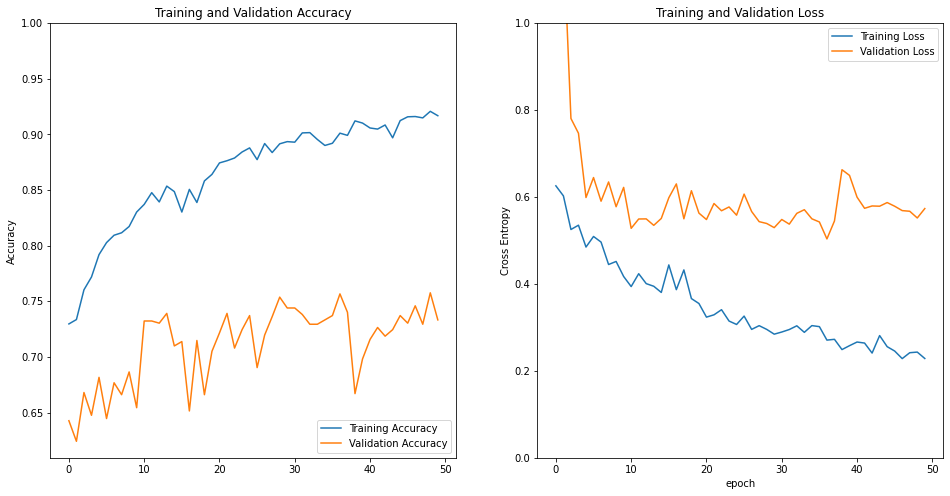

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 之前的結果

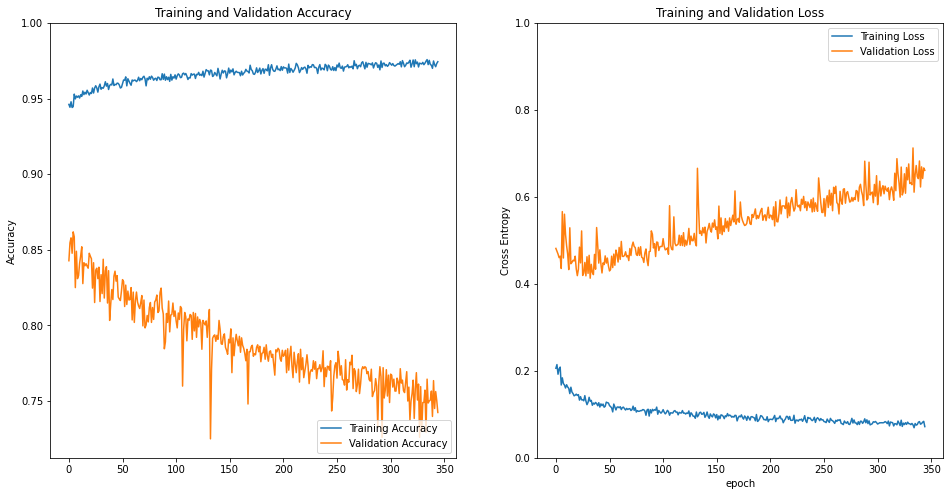

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

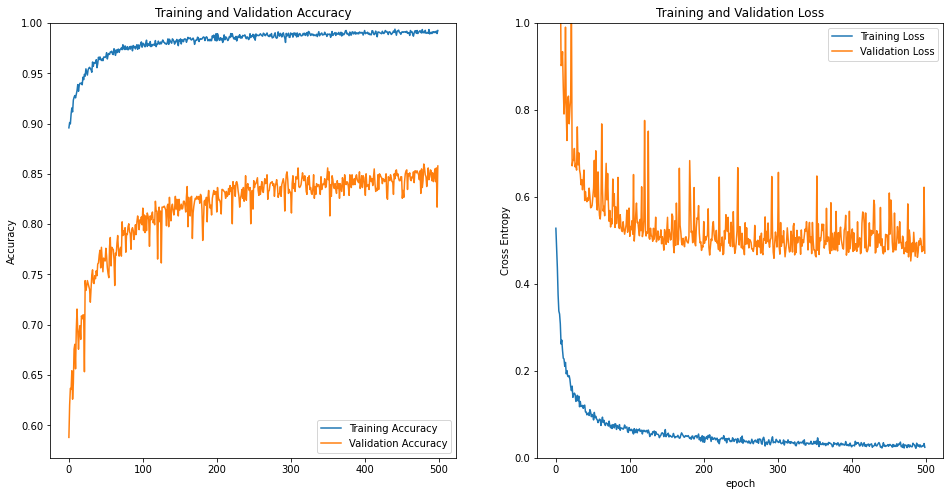

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 0821 訓練結果

In [14]:
# 參數設定
# seq = DataGenerator(df_trn2, '../data/folder_128/', batch_size=128)
# 模型訓練
history = tf_model.fit_generator(generator=seq_train, epochs=10, verbose=1, validation_data=seq_test,
                                 use_multiprocessing=False, workers=4)
# , use_multiprocessing=True, workers=4

Epoch 1/1000
95/95 [==============================] - 240s 3s/step - loss: 0.8943 - accuracy: 0.5177 - val_loss: 0.6642 - val_accuracy: 0.6191
Epoch 2/1000
95/95 [==============================] - 257s 3s/step - loss: 0.7868 - accuracy: 0.5290 - val_loss: 0.6675 - val_accuracy: 0.6191
Epoch 3/1000
95/95 [==============================] - 254s 3s/step - loss: 0.7223 - accuracy: 0.5521 - val_loss: 0.6654 - val_accuracy: 0.6191
Epoch 4/1000
95/95 [==============================] - 247s 3s/step - loss: 0.6947 - accuracy: 0.5718 - val_loss: 0.6651 - val_accuracy: 0.6191
Epoch 5/1000
95/95 [==============================] - 248s 3s/step - loss: 0.6805 - accuracy: 0.5892 - val_loss: 0.6659 - val_accuracy: 0.6191
Epoch 6/1000
95/95 [==============================] - 251s 3s/step - loss: 0.6750 - accuracy: 0.6000 - val_loss: 0.6648 - val_accuracy: 0.6191
Epoch 7/1000
95/95 [==============================] - 247s 3s/step - loss: 0.6725 - accuracy: 0.6086 - val_loss: 0.6670 - val_accuracy: 0.6191

Epoch 58/1000
95/95 [==============================] - 249s 3s/step - loss: 0.6509 - accuracy: 0.6299 - val_loss: 0.6864 - val_accuracy: 0.6191
Epoch 59/1000
95/95 [==============================] - 253s 3s/step - loss: 0.6513 - accuracy: 0.6277 - val_loss: 0.6824 - val_accuracy: 0.6191
Epoch 60/1000
95/95 [==============================] - 253s 3s/step - loss: 0.6494 - accuracy: 0.6300 - val_loss: 0.6856 - val_accuracy: 0.6194
Epoch 61/1000
95/95 [==============================] - 253s 3s/step - loss: 0.6500 - accuracy: 0.6275 - val_loss: 0.6849 - val_accuracy: 0.6197
Epoch 62/1000
95/95 [==============================] - 254s 3s/step - loss: 0.6493 - accuracy: 0.6315 - val_loss: 0.6796 - val_accuracy: 0.6197
Epoch 63/1000
95/95 [==============================] - 254s 3s/step - loss: 0.6490 - accuracy: 0.6259 - val_loss: 0.6693 - val_accuracy: 0.6194
Epoch 64/1000
95/95 [==============================] - 255s 3s/step - loss: 0.6496 - accuracy: 0.6310 - val_loss: 0.6783 - val_accuracy:

Epoch 115/1000
95/95 [==============================] - 254s 3s/step - loss: 0.6288 - accuracy: 0.6528 - val_loss: 0.6734 - val_accuracy: 0.6201
Epoch 116/1000
95/95 [==============================] - 251s 3s/step - loss: 0.6281 - accuracy: 0.6531 - val_loss: 0.6683 - val_accuracy: 0.6204
Epoch 117/1000
95/95 [==============================] - 266s 3s/step - loss: 0.6266 - accuracy: 0.6554 - val_loss: 0.6671 - val_accuracy: 0.6230
Epoch 118/1000
95/95 [==============================] - 256s 3s/step - loss: 0.6270 - accuracy: 0.6563 - val_loss: 0.6649 - val_accuracy: 0.6214
Epoch 119/1000
95/95 [==============================] - 256s 3s/step - loss: 0.6239 - accuracy: 0.6543 - val_loss: 0.6833 - val_accuracy: 0.6201
Epoch 120/1000
95/95 [==============================] - 258s 3s/step - loss: 0.6252 - accuracy: 0.6516 - val_loss: 0.6600 - val_accuracy: 0.6125
Epoch 121/1000
95/95 [==============================] - 253s 3s/step - loss: 0.6223 - accuracy: 0.6563 - val_loss: 0.6746 - val_ac

95/95 [==============================] - 253s 3s/step - loss: 0.4223 - accuracy: 0.8053 - val_loss: 0.7746 - val_accuracy: 0.6181
Epoch 228/1000
95/95 [==============================] - 253s 3s/step - loss: 0.4182 - accuracy: 0.8084 - val_loss: 0.7733 - val_accuracy: 0.5668
Epoch 229/1000
95/95 [==============================] - 253s 3s/step - loss: 0.4226 - accuracy: 0.8055 - val_loss: 0.7481 - val_accuracy: 0.5891
Epoch 230/1000
95/95 [==============================] - 257s 3s/step - loss: 0.4160 - accuracy: 0.8083 - val_loss: 0.7626 - val_accuracy: 0.6049
Epoch 231/1000
95/95 [==============================] - 260s 3s/step - loss: 0.4113 - accuracy: 0.8145 - val_loss: 0.7671 - val_accuracy: 0.5697
Epoch 232/1000
95/95 [==============================] - 261s 3s/step - loss: 0.4100 - accuracy: 0.8145 - val_loss: 0.7553 - val_accuracy: 0.6003
Epoch 233/1000
95/95 [==============================] - 257s 3s/step - loss: 0.4133 - accuracy: 0.8149 - val_loss: 0.7800 - val_accuracy: 0.6118


95/95 [==============================] - 220s 2s/step - loss: 0.1623 - accuracy: 0.9358 - val_loss: 1.0506 - val_accuracy: 0.5763
Epoch 340/1000
95/95 [==============================] - 215s 2s/step - loss: 0.1618 - accuracy: 0.9373 - val_loss: 1.0325 - val_accuracy: 0.6010
Epoch 341/1000
95/95 [==============================] - 214s 2s/step - loss: 0.1637 - accuracy: 0.9368 - val_loss: 1.1064 - val_accuracy: 0.5865
Epoch 342/1000
95/95 [==============================] - 218s 2s/step - loss: 0.1659 - accuracy: 0.9366 - val_loss: 1.0264 - val_accuracy: 0.6089
Epoch 343/1000
95/95 [==============================] - 221s 2s/step - loss: 0.1538 - accuracy: 0.9424 - val_loss: 1.0340 - val_accuracy: 0.6023
Epoch 344/1000
95/95 [==============================] - 225s 2s/step - loss: 0.1570 - accuracy: 0.9414 - val_loss: 1.1370 - val_accuracy: 0.5493
Epoch 345/1000
95/95 [==============================] - 225s 2s/step - loss: 0.1586 - accuracy: 0.9403 - val_loss: 1.0556 - val_accuracy: 0.5878


95/95 [==============================] - 225s 2s/step - loss: 0.0876 - accuracy: 0.9681 - val_loss: 1.2461 - val_accuracy: 0.6056
Epoch 452/1000
95/95 [==============================] - 223s 2s/step - loss: 0.0928 - accuracy: 0.9663 - val_loss: 1.3776 - val_accuracy: 0.5543
Epoch 453/1000
95/95 [==============================] - 218s 2s/step - loss: 0.0890 - accuracy: 0.9676 - val_loss: 1.2480 - val_accuracy: 0.5951
Epoch 454/1000
95/95 [==============================] - 216s 2s/step - loss: 0.0927 - accuracy: 0.9657 - val_loss: 1.2279 - val_accuracy: 0.5855
Epoch 455/1000
95/95 [==============================] - 215s 2s/step - loss: 0.0879 - accuracy: 0.9693 - val_loss: 1.2448 - val_accuracy: 0.5806
Epoch 456/1000
95/95 [==============================] - 219s 2s/step - loss: 0.0864 - accuracy: 0.9695 - val_loss: 1.2328 - val_accuracy: 0.5938
Epoch 457/1000
95/95 [==============================] - 220s 2s/step - loss: 0.0840 - accuracy: 0.9714 - val_loss: 1.2063 - val_accuracy: 0.6049


95/95 [==============================] - 222s 2s/step - loss: 0.0582 - accuracy: 0.9777 - val_loss: 1.3230 - val_accuracy: 0.5914
Epoch 564/1000
95/95 [==============================] - 228s 2s/step - loss: 0.0627 - accuracy: 0.9781 - val_loss: 1.3348 - val_accuracy: 0.5934
Epoch 565/1000
95/95 [==============================] - 222s 2s/step - loss: 0.0640 - accuracy: 0.9776 - val_loss: 1.3544 - val_accuracy: 0.5947
Epoch 566/1000
95/95 [==============================] - 219s 2s/step - loss: 0.0605 - accuracy: 0.9803 - val_loss: 1.3110 - val_accuracy: 0.5928
Epoch 567/1000
95/95 [==============================] - 213s 2s/step - loss: 0.0575 - accuracy: 0.9806 - val_loss: 1.4021 - val_accuracy: 0.6102
Epoch 568/1000
95/95 [==============================] - 213s 2s/step - loss: 0.0611 - accuracy: 0.9790 - val_loss: 1.4064 - val_accuracy: 0.5760
Epoch 569/1000
95/95 [==============================] - 217s 2s/step - loss: 0.0554 - accuracy: 0.9825 - val_loss: 1.3661 - val_accuracy: 0.6049


95/95 [==============================] - 219s 2s/step - loss: 0.0502 - accuracy: 0.9822 - val_loss: 1.4406 - val_accuracy: 0.5832
Epoch 676/1000
95/95 [==============================] - 220s 2s/step - loss: 0.0424 - accuracy: 0.9849 - val_loss: 1.4632 - val_accuracy: 0.5859
Epoch 677/1000
95/95 [==============================] - 220s 2s/step - loss: 0.0483 - accuracy: 0.9846 - val_loss: 1.3688 - val_accuracy: 0.5947
Epoch 678/1000
95/95 [==============================] - 222s 2s/step - loss: 0.0481 - accuracy: 0.9837 - val_loss: 1.5468 - val_accuracy: 0.5658
Epoch 679/1000
95/95 [==============================] - 219s 2s/step - loss: 0.0434 - accuracy: 0.9853 - val_loss: 1.3809 - val_accuracy: 0.5924
Epoch 680/1000
95/95 [==============================] - 215s 2s/step - loss: 0.0445 - accuracy: 0.9845 - val_loss: 1.4455 - val_accuracy: 0.5826
Epoch 681/1000
95/95 [==============================] - 215s 2s/step - loss: 0.0446 - accuracy: 0.9837 - val_loss: 1.4815 - val_accuracy: 0.5938


95/95 [==============================] - 220s 2s/step - loss: 0.0356 - accuracy: 0.9881 - val_loss: 1.4750 - val_accuracy: 0.6020
Epoch 788/1000
95/95 [==============================] - 219s 2s/step - loss: 0.0350 - accuracy: 0.9886 - val_loss: 1.4671 - val_accuracy: 0.5964
Epoch 789/1000
95/95 [==============================] - 219s 2s/step - loss: 0.0342 - accuracy: 0.9877 - val_loss: 1.5131 - val_accuracy: 0.5944
Epoch 790/1000
95/95 [==============================] - 220s 2s/step - loss: 0.0334 - accuracy: 0.9879 - val_loss: 1.4649 - val_accuracy: 0.6016
Epoch 791/1000
95/95 [==============================] - 222s 2s/step - loss: 0.0361 - accuracy: 0.9873 - val_loss: 1.5186 - val_accuracy: 0.5954
Epoch 792/1000
95/95 [==============================] - 222s 2s/step - loss: 0.0365 - accuracy: 0.9882 - val_loss: 1.4817 - val_accuracy: 0.5970
Epoch 793/1000
95/95 [==============================] - 220s 2s/step - loss: 0.0371 - accuracy: 0.9877 - val_loss: 1.4486 - val_accuracy: 0.6039


95/95 [==============================] - 223s 2s/step - loss: 0.0280 - accuracy: 0.9907 - val_loss: 1.5904 - val_accuracy: 0.5885
Epoch 900/1000
95/95 [==============================] - 220s 2s/step - loss: 0.0351 - accuracy: 0.9887 - val_loss: 1.5711 - val_accuracy: 0.5872
Epoch 901/1000
95/95 [==============================] - 221s 2s/step - loss: 0.0325 - accuracy: 0.9892 - val_loss: 1.5128 - val_accuracy: 0.5938
Epoch 902/1000
95/95 [==============================] - 221s 2s/step - loss: 0.0343 - accuracy: 0.9877 - val_loss: 1.6019 - val_accuracy: 0.5809
Epoch 903/1000
95/95 [==============================] - 222s 2s/step - loss: 0.0240 - accuracy: 0.9913 - val_loss: 1.5429 - val_accuracy: 0.6003
Epoch 904/1000
95/95 [==============================] - 221s 2s/step - loss: 0.0307 - accuracy: 0.9899 - val_loss: 1.5344 - val_accuracy: 0.5921
Epoch 905/1000
95/95 [==============================] - 219s 2s/step - loss: 0.0313 - accuracy: 0.9897 - val_loss: 1.5483 - val_accuracy: 0.5987


In [13]:
# print(df_trn[:8192].label.value_counts()[0]/8192)
# print(1 - df_trn[:8192].label.value_counts()[0]/8192)

0.69580078125
0.30419921875


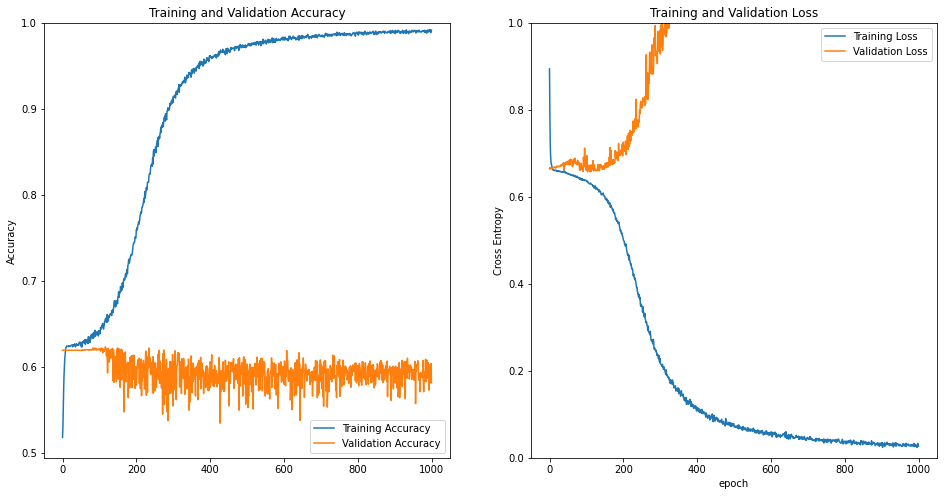

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 模型預測結果

In [15]:
tf_model = tf.keras.models.load_model('../callbacks/last0929/chaos_after_overfit_030_0929.h5')

In [16]:
prob_list_all = []
df = df_tmp
for i in range(len(df)):
    tmp = load_npz('../data/folder_128/' + df.GKF[i] + '/' + df.case[i] + '/' + df.final_key[i] + '.npz' )
    tmp = np.reshape(tmp, (1,128,128,64))
    score = tf_model.predict(tmp)[0][0]
    prob_list_all.append([df.GKF[i], df.case[i], df.final_key[i], df.label[i], score])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338


6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978


8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619


/root/anaconda3/envs/AI/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in short_scalars
  import sys


9317
9318
9319
9320
9321
9322
9323
9324
9325
9326
9327
9328
9329
9330
9331
9332
9333
9334
9335
9336
9337
9338
9339
9340
9341
9342
9343
9344
9345
9346
9347
9348
9349
9350
9351
9352
9353
9354
9355
9356
9357
9358
9359
9360
9361
9362
9363
9364
9365
9366
9367
9368
9369
9370
9371
9372
9373
9374
9375
9376
9377
9378
9379
9380
9381
9382
9383
9384
9385
9386
9387
9388
9389
9390
9391
9392
9393
9394
9395
9396
9397
9398
9399
9400
9401
9402
9403
9404
9405
9406
9407
9408
9409
9410
9411
9412
9413
9414
9415
9416
9417
9418
9419
9420
9421
9422
9423
9424
9425
9426
9427
9428
9429
9430
9431
9432
9433
9434
9435
9436
9437
9438
9439
9440
9441
9442
9443
9444
9445
9446
9447
9448
9449
9450
9451
9452
9453
9454
9455
9456
9457
9458
9459
9460
9461
9462
9463
9464
9465
9466
9467
9468
9469
9470
9471
9472
9473
9474
9475
9476
9477
9478
9479
9480
9481
9482
9483
9484
9485
9486
9487
9488
9489
9490
9491
9492
9493
9494
9495
9496
9497
9498
9499
9500
9501
9502
9503
9504
9505
9506
9507
9508
9509
9510
9511
9512
9513
9514
9515
9516


10797
10798
10799
10800
10801
10802
10803
10804
10805
10806
10807
10808
10809
10810
10811
10812
10813
10814
10815
10816
10817
10818
10819
10820
10821
10822
10823
10824
10825
10826
10827
10828
10829
10830
10831
10832
10833
10834
10835
10836
10837
10838
10839
10840
10841
10842
10843
10844
10845
10846
10847
10848
10849
10850
10851
10852
10853
10854
10855
10856
10857
10858
10859
10860
10861
10862
10863
10864
10865
10866
10867
10868
10869
10870
10871
10872
10873
10874
10875
10876
10877
10878
10879
10880
10881
10882
10883
10884
10885
10886
10887
10888
10889
10890
10891
10892
10893
10894
10895
10896
10897
10898
10899
10900
10901
10902
10903
10904
10905
10906
10907
10908
10909
10910
10911
10912
10913
10914
10915
10916
10917
10918
10919
10920
10921
10922
10923
10924
10925
10926
10927
10928
10929
10930
10931
10932
10933
10934
10935
10936
10937
10938
10939
10940
10941
10942
10943
10944
10945
10946
10947
10948
10949
10950
10951
10952
10953
10954
10955
10956
10957
10958
10959
10960
10961
10962
1096

12164
12165
12166
12167
12168
12169
12170
12171
12172
12173
12174
12175
12176
12177
12178
12179
12180
12181
12182
12183
12184
12185
12186
12187
12188
12189
12190
12191
12192
12193
12194
12195
12196
12197
12198
12199
12200
12201
12202
12203
12204
12205
12206
12207
12208
12209
12210
12211
12212
12213
12214
12215
12216
12217
12218
12219
12220
12221
12222
12223
12224
12225
12226
12227
12228
12229
12230
12231
12232
12233
12234
12235
12236
12237
12238
12239
12240
12241
12242
12243
12244
12245
12246
12247
12248
12249
12250
12251
12252
12253
12254
12255
12256
12257
12258
12259
12260
12261
12262
12263
12264
12265
12266
12267
12268
12269
12270
12271
12272
12273
12274
12275
12276
12277
12278
12279
12280
12281
12282
12283
12284
12285
12286
12287
12288
12289
12290
12291
12292
12293
12294
12295
12296
12297
12298
12299
12300
12301
12302
12303
12304
12305
12306
12307
12308
12309
12310
12311
12312
12313
12314
12315
12316
12317
12318
12319
12320
12321
12322
12323
12324
12325
12326
12327
12328
12329
1233

13530
13531
13532
13533
13534
13535
13536
13537
13538
13539
13540
13541
13542
13543
13544
13545
13546
13547
13548
13549
13550
13551
13552
13553
13554
13555
13556
13557
13558
13559
13560
13561
13562
13563
13564
13565
13566
13567
13568
13569
13570
13571
13572
13573
13574
13575
13576
13577
13578
13579
13580
13581
13582
13583
13584
13585
13586
13587
13588
13589
13590
13591
13592
13593
13594
13595
13596
13597
13598
13599
13600
13601
13602
13603
13604
13605
13606
13607
13608
13609
13610
13611
13612
13613
13614
13615
13616
13617
13618
13619
13620
13621
13622
13623
13624
13625
13626
13627
13628
13629
13630
13631
13632
13633
13634
13635
13636
13637
13638
13639
13640
13641
13642
13643
13644
13645
13646
13647
13648
13649
13650
13651
13652
13653
13654
13655
13656
13657
13658
13659
13660
13661
13662
13663
13664
13665
13666
13667
13668
13669
13670
13671
13672
13673
13674
13675
13676
13677
13678
13679
13680
13681
13682
13683
13684
13685
13686
13687
13688
13689
13690
13691
13692
13693
13694
13695
1369

14896
14897
14898
14899
14900
14901
14902
14903
14904
14905
14906
14907
14908
14909
14910
14911
14912
14913
14914
14915
14916
14917
14918
14919
14920
14921
14922
14923
14924
14925
14926
14927
14928
14929
14930
14931
14932
14933
14934
14935
14936
14937
14938
14939
14940
14941
14942
14943
14944
14945
14946
14947
14948
14949
14950
14951
14952
14953
14954
14955
14956
14957
14958
14959
14960
14961
14962
14963
14964
14965
14966
14967
14968
14969
14970
14971
14972
14973
14974
14975
14976
14977
14978
14979
14980
14981
14982
14983
14984
14985
14986
14987
14988
14989
14990
14991
14992
14993
14994
14995
14996
14997
14998
14999
15000
15001
15002
15003
15004
15005
15006
15007
15008
15009
15010
15011
15012
15013
15014
15015
15016
15017
15018
15019
15020
15021
15022
15023
15024
15025
15026
15027
15028
15029
15030
15031
15032
15033
15034
15035
15036
15037
15038
15039
15040
15041
15042
15043
15044
15045
15046
15047
15048
15049
15050
15051
15052
15053
15054
15055
15056
15057
15058
15059
15060
15061
1506

In [17]:
df_score_all = pd.DataFrame(prob_list_all, columns=['GKF', 'case', 'final_key', 'label', 'score'])

In [18]:
df_score_all

,GKF,case,final_key,label,score
0,test,case,P1887_S01_R01_Y_S1,Y,0.999938
1,test,case,P1887_S01_R02_Y_S1,Y,0.999972
2,train,case,P2310_S01_R03_Y_S1,Y,0.998738
3,train,case,P2310_S01_R02_Y_S1,Y,0.999463
4,train,case,P2310_S01_R01_Y_S1,Y,0.999243
...,...,...,...,...,...
15120,train,control,P2506_S01_R02_N_S1,N,0.111485
15121,train,control,P2506_S01_R03_N_S1,N,0.113972
15122,train,control,P6075_S01_R02_N_S1,N,0.092666
15123,train,control,P6075_S01_R01_N_S1,N,0.093668


In [19]:
df_score_all['final_key'] = df_score_all.final_key.str.slice(0,15)
df_score_all

,GKF,case,final_key,label,score
0,test,case,P1887_S01_R01_Y,Y,0.999938
1,test,case,P1887_S01_R02_Y,Y,0.999972
2,train,case,P2310_S01_R03_Y,Y,0.998738
3,train,case,P2310_S01_R02_Y,Y,0.999463
4,train,case,P2310_S01_R01_Y,Y,0.999243
...,...,...,...,...,...
15120,train,control,P2506_S01_R02_N,N,0.111485
15121,train,control,P2506_S01_R03_N,N,0.113972
15122,train,control,P6075_S01_R02_N,N,0.092666
15123,train,control,P6075_S01_R01_N,N,0.093668


In [20]:
df_score_all.case.value_counts()

control    9425
case       5700
Name: case, dtype: int64

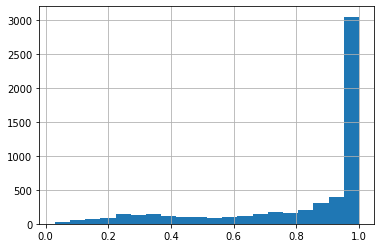

In [21]:
df_score_all.loc[df_score_all.label == 'Y', 'score'].hist(bins=20,)

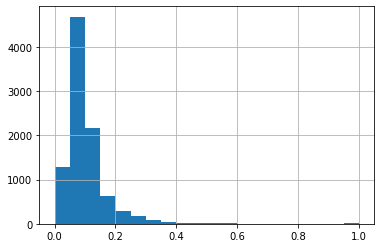

In [22]:
df_score_all.loc[df_score_all.label == 'N', 'score'].hist(bins=20)

In [23]:
y_score = df_score_all.loc[df_score_all.label == 'Y', 'score'].values
n_score = df_score_all.loc[df_score_all.label == 'N', 'score'].values

In [24]:
df_score_all.loc[[2250]]

,GKF,case,final_key,label,score
2250,test,case,P1193_S01_R01_Y,Y,0.999277


In [25]:
y_score.max(), y_score.min(), n_score.max(), n_score.min()

(1.0, 0.02881821244955063, 0.9996048808097839, 0.0)

In [26]:
df_score_all.loc[(df_score_all.score < 0.01) & (df_score_all.label == 'Y'), :]

,GKF,case,final_key,label,score


In [27]:
df_score_all.loc[(df_score_all.score > 0.9) & (df_score_all.label == 'N'), :]

,GKF,case,final_key,label,score
5906,train,control,P2985_S01_R01_N,N,0.982450
6598,test,control,P4691_S01_R03_N,N,0.928254
6841,test,control,P4113_S01_R02_N,N,0.999605
10044,test,control,P3701_S01_R02_N,N,0.975543
10897,test,control,P4611_S01_R05_N,N,0.980437
12255,test,control,P5134_S01_R03_N,N,0.974199
13671,test,control,P5631_S01_R03_N,N,0.965220
15008,test,control,P6077_S01_R02_N,N,0.954410


In [28]:
df_score_all.loc[df_score_all.score == y_score.min(), :]

,GKF,case,final_key,label,score
4929,test,case,P1700_S01_R05_Y,Y,0.028818


In [29]:
np.mean(df_score_all.loc[df_score_all.label == 'Y', 'score'])

0.8180987507627722

In [30]:
np.mean(df_score_all.loc[df_score_all.label == 'N', 'score'])

0.10220712001689905

## 製作mapping表

In [31]:
df_mapping = pd.read_csv('../final_id_mapping.csv')
df_mapping

,final_key,PID,PID_STUDY,SID,RID,GKF,case,PATIENT_ID,study,series,length,study_date,acquisition_time,position
0,P1887_S01_R01_Y,psuedoID_1887,psuedoID_1887_S001,1,1,1,0,1.2.840.24652139151124160224891431703118616727...,1.2.840.25020658949133231411291332105612210813083,1.2.840.67424224310376501373210495162902461118,59,20180530,91127.20000,FFS
1,P1887_S01_R02_Y,psuedoID_1887,psuedoID_1887_S001,2,2,1,0,1.2.840.24652139151124160224891431703118616727...,1.2.840.25020658949133231411291332105612210813083,1.2.840.7416611515915281971941428914215165151210,59,20180530,91425.75000,FFS
2,P2310_S01_R03_Y,psuedoID_2310,psuedoID_2310_S001,1,3,5,0,1.2.840.13323514684248522824118117224824161262...,1.2.840.22811225363129249462006576542618423816157,1.2.840.8195253119492294721146136302056424841139,98,20180626,225032.60000,FFS
3,P2310_S01_R02_Y,psuedoID_2310,psuedoID_2310_S001,2,2,5,0,1.2.840.13323514684248522824118117224824161262...,1.2.840.22811225363129249462006576542618423816157,1.2.840.7593127191190846932323934079296189,98,20180626,224844.35000,FFS
4,P2310_S01_R01_Y,psuedoID_2310,psuedoID_2310_S001,3,1,5,0,1.2.840.13323514684248522824118117224824161262...,1.2.840.22811225363129249462006576542618423816157,1.2.840.23612919394279491611671392182411888177143,98,20180626,224653.35000,FFS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15120,P2506_S01_R02_N,psuedoID_2506,psuedoID_2506_S001,3,2,2,1,1.2.840.186167525423239133408514164261692043218,1.2.840.44134691771101210183498121517711110315...,1.2.840.90203721121012392361492302535048153512...,61,20181108,152951.15730,FFS
15121,P2506_S01_R03_N,psuedoID_2506,psuedoID_2506_S001,4,3,2,1,1.2.840.186167525423239133408514164261692043218,1.2.840.44134691771101210183498121517711110315...,1.2.840.132901788881377246719510812676189183161,61,20181108,152402.62640,FFS
15122,P6075_S01_R02_N,psuedoID_6075,psuedoID_6075_S001,1,2,4,1,1.2.840.2197295328252185151189221225130521006743,1.2.840.16865162199130204109961777696251106165100,1.2.840.78206176209594927531274918125073766152,83,20180129,93740.63264,HFS
15123,P6075_S01_R01_N,psuedoID_6075,psuedoID_6075_S001,2,1,4,1,1.2.840.2197295328252185151189221225130521006743,1.2.840.16865162199130204109961777696251106165100,1.2.840.71102212581032063221225123221219141101...,83,20180129,93421.26563,HFS


In [32]:
df_merge = pd.merge(df_score_all, df_mapping, how='inner', on=['final_key'])
df_merge

,GKF_x,case_x,final_key,label,score,PID,PID_STUDY,SID,RID,GKF_y,case_y,PATIENT_ID,study,series,length,study_date,acquisition_time,position
0,test,case,P1887_S01_R01_Y,Y,0.999938,psuedoID_1887,psuedoID_1887_S001,1,1,1,0,1.2.840.24652139151124160224891431703118616727...,1.2.840.25020658949133231411291332105612210813083,1.2.840.67424224310376501373210495162902461118,59,20180530,91127.20000,FFS
1,test,case,P1887_S01_R02_Y,Y,0.999972,psuedoID_1887,psuedoID_1887_S001,2,2,1,0,1.2.840.24652139151124160224891431703118616727...,1.2.840.25020658949133231411291332105612210813083,1.2.840.7416611515915281971941428914215165151210,59,20180530,91425.75000,FFS
2,train,case,P2310_S01_R03_Y,Y,0.998738,psuedoID_2310,psuedoID_2310_S001,1,3,5,0,1.2.840.13323514684248522824118117224824161262...,1.2.840.22811225363129249462006576542618423816157,1.2.840.8195253119492294721146136302056424841139,98,20180626,225032.60000,FFS
3,train,case,P2310_S01_R02_Y,Y,0.999463,psuedoID_2310,psuedoID_2310_S001,2,2,5,0,1.2.840.13323514684248522824118117224824161262...,1.2.840.22811225363129249462006576542618423816157,1.2.840.7593127191190846932323934079296189,98,20180626,224844.35000,FFS
4,train,case,P2310_S01_R01_Y,Y,0.999243,psuedoID_2310,psuedoID_2310_S001,3,1,5,0,1.2.840.13323514684248522824118117224824161262...,1.2.840.22811225363129249462006576542618423816157,1.2.840.23612919394279491611671392182411888177143,98,20180626,224653.35000,FFS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15120,train,control,P2506_S01_R02_N,N,0.111485,psuedoID_2506,psuedoID_2506_S001,3,2,2,1,1.2.840.186167525423239133408514164261692043218,1.2.840.44134691771101210183498121517711110315...,1.2.840.90203721121012392361492302535048153512...,61,20181108,152951.15730,FFS
15121,train,control,P2506_S01_R03_N,N,0.113972,psuedoID_2506,psuedoID_2506_S001,4,3,2,1,1.2.840.186167525423239133408514164261692043218,1.2.840.44134691771101210183498121517711110315...,1.2.840.132901788881377246719510812676189183161,61,20181108,152402.62640,FFS
15122,train,control,P6075_S01_R02_N,N,0.092666,psuedoID_6075,psuedoID_6075_S001,1,2,4,1,1.2.840.2197295328252185151189221225130521006743,1.2.840.16865162199130204109961777696251106165100,1.2.840.78206176209594927531274918125073766152,83,20180129,93740.63264,HFS
15123,train,control,P6075_S01_R01_N,N,0.093668,psuedoID_6075,psuedoID_6075_S001,2,1,4,1,1.2.840.2197295328252185151189221225130521006743,1.2.840.16865162199130204109961777696251106165100,1.2.840.71102212581032063221225123221219141101...,83,20180129,93421.26563,HFS


In [33]:
features = ['GKF_y', 'GKF_x', 'case_x', 'final_key', 'label', 'score',  'length', 'study_date', 'position']

In [34]:
df_merge = df_merge[features]
df_merge

,GKF_y,GKF_x,case_x,final_key,label,score,length,study_date,position
0,1,test,case,P1887_S01_R01_Y,Y,0.999938,59,20180530,FFS
1,1,test,case,P1887_S01_R02_Y,Y,0.999972,59,20180530,FFS
2,5,train,case,P2310_S01_R03_Y,Y,0.998738,98,20180626,FFS
3,5,train,case,P2310_S01_R02_Y,Y,0.999463,98,20180626,FFS
4,5,train,case,P2310_S01_R01_Y,Y,0.999243,98,20180626,FFS
...,...,...,...,...,...,...,...,...,...
15120,2,train,control,P2506_S01_R02_N,N,0.111485,61,20181108,FFS
15121,2,train,control,P2506_S01_R03_N,N,0.113972,61,20181108,FFS
15122,4,train,control,P6075_S01_R02_N,N,0.092666,83,20180129,HFS
15123,4,train,control,P6075_S01_R01_N,N,0.093668,83,20180129,HFS


In [35]:
df_merge.columns = ['KF', 'GKF', 'case', 'final_key', 'label', 'score', 'length', 'study_date','position']
df_merge

,KF,GKF,case,final_key,label,score,length,study_date,position
0,1,test,case,P1887_S01_R01_Y,Y,0.999938,59,20180530,FFS
1,1,test,case,P1887_S01_R02_Y,Y,0.999972,59,20180530,FFS
2,5,train,case,P2310_S01_R03_Y,Y,0.998738,98,20180626,FFS
3,5,train,case,P2310_S01_R02_Y,Y,0.999463,98,20180626,FFS
4,5,train,case,P2310_S01_R01_Y,Y,0.999243,98,20180626,FFS
...,...,...,...,...,...,...,...,...,...
15120,2,train,control,P2506_S01_R02_N,N,0.111485,61,20181108,FFS
15121,2,train,control,P2506_S01_R03_N,N,0.113972,61,20181108,FFS
15122,4,train,control,P6075_S01_R02_N,N,0.092666,83,20180129,HFS
15123,4,train,control,P6075_S01_R01_N,N,0.093668,83,20180129,HFS


## 資料儲存

In [36]:
df_merge.to_csv('./df_score_model2_last30_0929.csv', index=False)

In [37]:
pd.read_csv('./df_score_model2_last30_0929.csv')

,KF,GKF,case,final_key,label,score,length,study_date,position
0,1,test,case,P1887_S01_R01_Y,Y,0.999938,59,20180530,FFS
1,1,test,case,P1887_S01_R02_Y,Y,0.999972,59,20180530,FFS
2,5,train,case,P2310_S01_R03_Y,Y,0.998738,98,20180626,FFS
3,5,train,case,P2310_S01_R02_Y,Y,0.999463,98,20180626,FFS
4,5,train,case,P2310_S01_R01_Y,Y,0.999243,98,20180626,FFS
...,...,...,...,...,...,...,...,...,...
15120,2,train,control,P2506_S01_R02_N,N,0.111485,61,20181108,FFS
15121,2,train,control,P2506_S01_R03_N,N,0.113972,61,20181108,FFS
15122,4,train,control,P6075_S01_R02_N,N,0.092666,83,20180129,HFS
15123,4,train,control,P6075_S01_R01_N,N,0.093668,83,20180129,HFS
